# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица users (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

In [3]:
calls = pd.read_csv('/datasets/calls.csv') 
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [4]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Таблица internet (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [5]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Описание тарифов\
Тариф «Смарт»\
Ежемесячная плата: 550 рублей\
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
минута разговора: 3 рубля\
сообщение: 3 рубля\
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»\
Ежемесячная плата: 1950 рублей\
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
минута разговора: 1 рубль\
сообщение: 1 рубль\
1 Гб интернет-трафика: 150 рублей\
\
Примечание:\
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.\
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Вывод

* Ни одна таблица не содержит столбцы с форматом datetime, нужно исправить это
* Есть ненужный столбец Unnamed, который не прописан в описании к таблицам, его следует удалить. Также присутсвуют столбцы 'id', которые тоже не несут в себе ценной информации
* Есть смысл округлить значения в столбцах с минутами, т.к.это облегчит дальнейший анализ
* Явных дубликатов обнаружено не было, пропущенных значений для замены тоже

## Предобработка данных

### Формат даты

In [7]:
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date']=pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date']=pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

### Удаление столбца

In [8]:
internet.drop('id', axis=1, inplace=True)
calls.drop('id', axis=1, inplace=True)
messages.drop('id', axis=1, inplace=True)

### Округление

In [9]:
calls['duration'] = np.ceil(calls['duration'])

### Преобразование

In [10]:
tariffs['mb_per_month_included']=tariffs['mb_per_month_included']/1024
tariffs = tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
tariffs['gb_per_month_included'] = tariffs['gb_per_month_included'].astype('int')
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Вывод

Мы подготовили данные для расчета выручки.

## Подготовка пользовательских данных

### Добавляем столбец `month`

In [11]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

### Группировка данных

Группируем таблицу так, чтобы можно было увидеть кол-во звонков каждого пользователя за каждый месяц.

In [12]:
calls_number = calls.groupby(['user_id', 'month'])[['call_date']].count()
calls_number.columns = ['number_of_calls']
calls_number

number_of_calls
user_id month                 
1000    5                   22
        6                   43
        7                   47
        8                   52
        9                   58
...                        ...
1498    10                  41
1499    9                    9
        10                  68
        11                  74
        12                  69

[3174 rows x 1 columns]

Теперь узнаем длительность их звонков.

In [13]:
calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index() 
calls.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls

,user_id,month,calls_count,calls_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


Стоит сложить все использованные мегабайты, после этого превратим их в гигабайты и приведем в целочисленный формат.

In [14]:
internet_used = internet.groupby(['user_id', 'month'])[['mb_used']].sum()
internet_used['gb_used'] = internet_used['mb_used']/1024
internet_used['gb_used'] = np.ceil(internet_used['gb_used'])
internet_used.drop('mb_used', axis=1, inplace=True)
internet_used['gb_used'] = internet_used['gb_used'].astype('int')
internet_used

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Снова соединяем все данные.

In [15]:
internet = internet_used.merge(calls, on=['user_id', 'month'])
internet

,user_id,month,gb_used,calls_count,calls_sum
0,1000,5,3,22,159.0
1,1000,6,23,43,172.0
2,1000,7,14,47,340.0
3,1000,8,14,52,408.0
4,1000,9,15,58,466.0
...,...,...,...,...,...
3158,1498,10,21,41,247.0
3159,1499,9,2,9,70.0
3160,1499,10,18,68,449.0
3161,1499,11,18,74,612.0


Считаем кол-во отправленных сообщений.

In [16]:
messages_number = messages.groupby(['user_id', 'month'])[['month']].count()
messages_number.columns = ['number_of_msg']
messages_number

number_of_msg
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

Делаем общую таблицу.

In [17]:
users_merged = internet.merge(messages_number, on=['user_id', 'month'])
users_merged

,user_id,month,gb_used,calls_count,calls_sum,number_of_msg
0,1000,5,3,22,159.0,22
1,1000,6,23,43,172.0,60
2,1000,7,14,47,340.0,75
3,1000,8,14,52,408.0,81
4,1000,9,15,58,466.0,57
...,...,...,...,...,...,...
2662,1498,10,21,41,247.0,42
2663,1499,9,2,9,70.0,11
2664,1499,10,18,68,449.0,48
2665,1499,11,18,74,612.0,59


Теперь стоит соединить с таблицей с общей информацией о пользователях.

In [18]:
users_merged = users_merged.reset_index()
data = users_merged.merge(users, on='user_id', how='outer')
data = data.rename(columns={'tariff': 'tariff_name'})

Соединяем с таблицей о тарифах.

In [19]:
data = data.merge(tariffs, on="tariff_name")
data

,index,user_id,month,gb_used,calls_count,calls_sum,number_of_msg,age,churn_date,city,...,last_name,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0.0,1000,5.0,3.0,22.0,159.0,22.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
1,1.0,1000,6.0,23.0,43.0,172.0,60.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
2,2.0,1000,7.0,14.0,47.0,340.0,75.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
3,3.0,1000,8.0,14.0,52.0,408.0,81.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
4,4.0,1000,9.0,15.0,58.0,466.0,57.0,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,NaN,1456,NaN,NaN,NaN,NaN,NaN,40,NaT,Санкт-Петербург,...,Андропова,2018-08-25,smart,50,15,500,550,200,3,3
2744,NaN,1462,NaN,NaN,NaN,NaN,NaN,72,NaT,Тольятти,...,Абрамычева,2018-10-29,smart,50,15,500,550,200,3,3
2745,NaN,1479,NaN,NaN,NaN,NaN,NaN,40,NaT,Хабаровск,...,Богданов,2018-07-03,smart,50,15,500,550,200,3,3
2746,NaN,1489,NaN,NaN,NaN,NaN,NaN,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15,500,550,200,3,3


### Подсчет выручки

Считаем, сколько денег принес компании пользователь за каждый месяц и добавляем эти данные в датафрейм.

In [20]:
def monthly_income(row):
    revenue = 0
    if row['calls_sum'] > row['minutes_included']:
        revenue+=((row['calls_sum']-row['minutes_included'])*row['rub_per_minute'])
    if row['gb_used'] > row['gb_per_month_included']:
        revenue+=((row['gb_used']-row['gb_per_month_included'])*row['rub_per_gb'])
    if row['number_of_msg'] > row['messages_included']:
        revenue+=((row['number_of_msg'])-row['messages_included']*row['rub_per_message'])
    else:
        revenue+=0
    return revenue

In [21]:
data['monthly_income'] = (data.apply(monthly_income, axis=1)) + data['rub_monthly_fee']
data

,index,user_id,month,gb_used,calls_count,calls_sum,number_of_msg,age,churn_date,city,...,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,monthly_income
0,0.0,1000,5.0,3.0,22.0,159.0,22.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
1,1.0,1000,6.0,23.0,43.0,172.0,60.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
2,2.0,1000,7.0,14.0,47.0,340.0,75.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
3,3.0,1000,8.0,14.0,52.0,408.0,81.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
4,4.0,1000,9.0,15.0,58.0,466.0,57.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,NaN,1456,NaN,NaN,NaN,NaN,NaN,40,NaT,Санкт-Петербург,...,2018-08-25,smart,50,15,500,550,200,3,3,550.0
2744,NaN,1462,NaN,NaN,NaN,NaN,NaN,72,NaT,Тольятти,...,2018-10-29,smart,50,15,500,550,200,3,3,550.0
2745,NaN,1479,NaN,NaN,NaN,NaN,NaN,40,NaT,Хабаровск,...,2018-07-03,smart,50,15,500,550,200,3,3,550.0
2746,NaN,1489,NaN,NaN,NaN,NaN,NaN,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15,500,550,200,3,3,550.0


### Вывод

Мы включили в датафрейм данные о выручке для каждого пользователя в каждом месяце.

## Анализ данных

### Гистограммы для общего кол-ва трафика

Группируем данные по типу тарифа и суммируем весь израсходованный пользователями трафик.

In [22]:
tariff_smart_sum = (data
                .query('tariff_name == "smart"')
                .pivot_table(
                    index='month', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('sum')
                )
)

In [23]:
tariff_ultra_sum = (data
                .query('tariff_name == "ultra"')
                .pivot_table(
                    index='month', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('sum')
                )
)

Построим график по общему распределению трафика за весь период.

<AxesSubplot:ylabel='Frequency'>

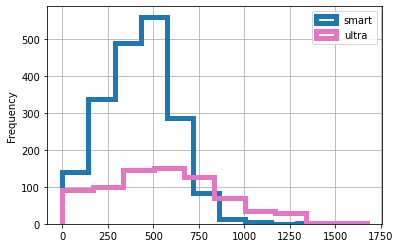

In [24]:
ax = data[data['tariff_name']=='smart']['calls_sum'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data[data['tariff_name']=='ultra']['calls_sum'].plot(
    ax=ax,
    kind='hist',
    bins=10,
    label='ultra',
    grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)


<AxesSubplot:ylabel='Frequency'>

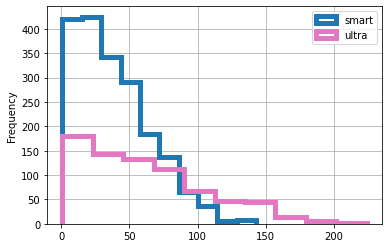

In [25]:
ax = data[data['tariff_name']=='smart']['number_of_msg'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data[data['tariff_name']=='ultra']['number_of_msg'].plot(
    kind='hist',
    bins=10,
    label='ultra',
    grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)

<AxesSubplot:ylabel='Frequency'>

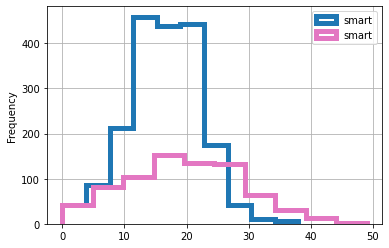

In [26]:
ax = data[data['tariff_name']=='smart']['gb_used'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data[data['tariff_name']=='ultra']['gb_used'].plot(
    kind='hist',
    bins=10,
    label='smart',
    grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)

Пользователи тарифа smart израсходовали намного больше трафика, чем пользователи тарифа ultra во всех сферах: минутах, сообщениях и интернет-трафике.

Строим гистограмму по длительности звонков за каждый месяц.

<AxesSubplot:xlabel='month'>

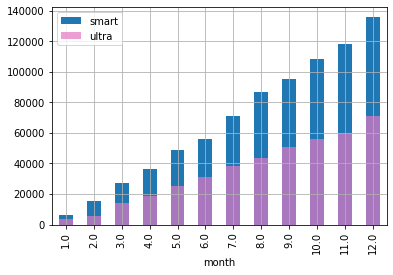

In [27]:
sum_calls_smart = tariff_smart_sum.pivot_table(index='month', values='calls_sum', aggfunc='sum')
sum_calls_ultra = tariff_ultra_sum.pivot_table(index='month', values='calls_sum', aggfunc='sum')
ax = sum_calls_smart.plot(kind='bar', y='calls_sum', label='smart')
sum_calls_ultra.plot(
    kind='bar',
    y='calls_sum',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True
)

Видим, что кол-во пользователей сильно выросло в течение года, а также можем сделать вывод, что на тарифе smart разговоры длятся дольше.

<AxesSubplot:xlabel='month'>

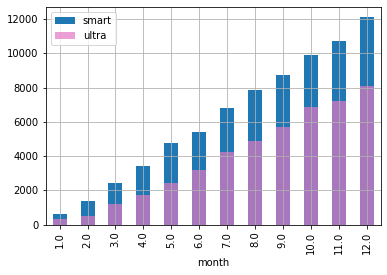

In [28]:
sum_msg_smart = tariff_smart_sum.pivot_table(index='month', values='number_of_msg', aggfunc='sum')
sum_msg_ultra = tariff_ultra_sum.pivot_table(index='month', values='number_of_msg', aggfunc='sum')
ax = sum_msg_smart.plot(kind='bar', y='number_of_msg', label='smart')
sum_msg_ultra.plot(
    kind='bar',
    y='number_of_msg',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True
)

Также дела обстоят и с сообщениями - их кол-во растет с каждым месяцем, но при этом на тарифе smart их снова больше.

<AxesSubplot:xlabel='month'>

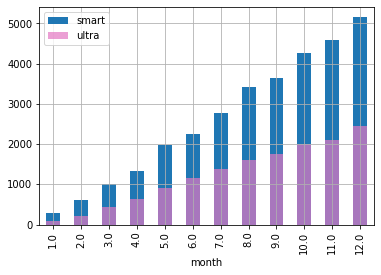

In [29]:
sum_gb_smart = tariff_smart_sum.pivot_table(index='month', values='gb_used', aggfunc='sum')
sum_gb_ultra = tariff_ultra_sum.pivot_table(index='month', values='gb_used', aggfunc='sum')
ax = sum_gb_smart.plot(kind='bar', y='gb_used', label='smart')
sum_gb_ultra.plot(
    kind='bar',
    y='gb_used',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True
)

Замечаем такую же тенденцию с израсходованным интернет-трафиком.

### Гистограммы для средних значений

In [30]:
tariff_smart_median = (data
                .query('tariff_name == "smart"')
                .pivot_table(
                    index='month', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('median')
                )
)

In [31]:
tariff_ultra_median = (data
                .query('tariff_name == "ultra"')
                .pivot_table(
                    index='month', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('median')
                )
)

<AxesSubplot:xlabel='month'>

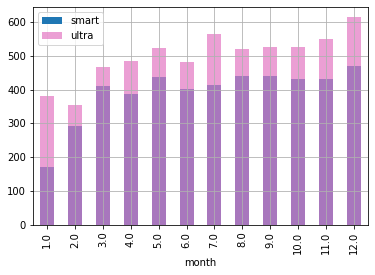

In [32]:
median_calls_smart = tariff_smart_median.pivot_table(index='month', values='calls_sum', aggfunc='median')
median_calls_ultra = tariff_ultra_median.pivot_table(index='month', values='calls_sum', aggfunc='median')
ax = median_calls_smart.plot(kind='bar', y='calls_sum', label='smart')
median_calls_ultra.plot(
    kind='bar',
    y='calls_sum',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True,
)

Здесть ситуация меняется — средние значения по длительности звонков у пользователей тарифа ultra выше.

In [33]:
data_smart_median = (data
                .query('tariff_name == "smart"')
                .pivot_table(
                    index='user_id', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('median')
                )
)

In [34]:
data_ultra_median = (data
                .query('tariff_name == "ultra"')
                .pivot_table(
                    index='user_id', 
                    values = ('calls_sum', 'number_of_msg', 'gb_used'), 
                    aggfunc = ('median')
                )
)

<AxesSubplot:ylabel='Frequency'>

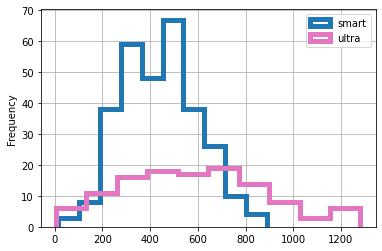

In [35]:
ax=data_smart_median['calls_sum'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data_ultra_median['calls_sum'].plot(
    kind='hist',
    bins=10,
    label='ultra',
    ax=ax, grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)

График по общему распределению это подтверждает — хоть истраченного трафика больше у пользователей smart, средние значения выше у пользователей ultra.

<AxesSubplot:xlabel='month'>

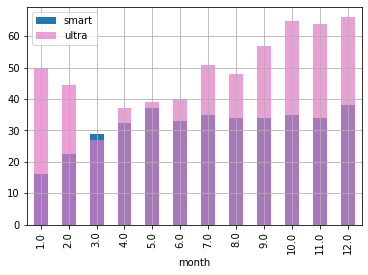

In [36]:
median_msg_smart = tariff_smart_median.pivot_table(index='month', values='number_of_msg', aggfunc='median')
median_msg_ultra = tariff_ultra_median.pivot_table(index='month', values='number_of_msg', aggfunc='median')
ax = median_msg_smart.plot(kind='bar', y='number_of_msg', label='smart')
median_msg_ultra.plot(
    kind='bar',
    y='number_of_msg',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True
)

Почти такая же ситуация с сообщениями — почти всегда у тарифа ultra выше средние значения, только в марте значения тарифа smart их обошли.

<AxesSubplot:ylabel='Frequency'>

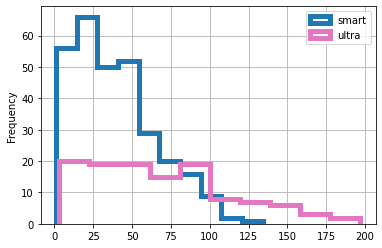

In [37]:
ax=data_smart_median['number_of_msg'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data_ultra_median['number_of_msg'].plot(
    kind='hist',
    bins=10,
    label='ultra',
    ax=ax, grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)

Здесь видим потверждение тенденции.

<AxesSubplot:xlabel='month'>

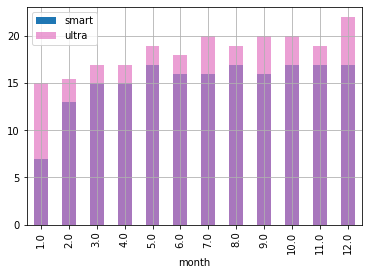

In [38]:
median_gb_smart = tariff_smart_median.pivot_table(index='month', values='gb_used', aggfunc='median')
median_gb_ultra = tariff_ultra_median.pivot_table(index='month', values='gb_used', aggfunc='median')
ax = median_gb_smart.plot(kind='bar', y='gb_used', label='smart')
median_gb_ultra.plot(
    kind='bar',
    y='gb_used',
    label='ultra',
    ax=ax, alpha=0.7,
    color='C6',
    grid=True,
    legend=True
)

С интернет-трафиком разница в средних показателях не такая большая, но все же есть. Почти везде лидирует ultra.

<AxesSubplot:ylabel='Frequency'>

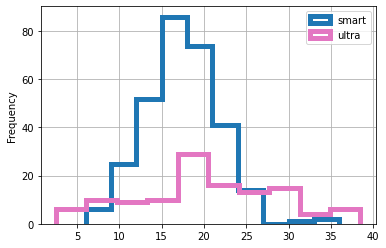

In [39]:
ax=data_smart_median['gb_used'].plot(kind='hist', bins=10, label='smart', grid=True, histtype='step', linewidth=5, legend=True)
data_ultra_median['gb_used'].plot(
    kind='hist',
    bins=10,
    label='ultra',
    ax=ax, grid=True,
    histtype='step', 
    linewidth=5,
    legend=True,
    color='C6'
)

В интернет-трафике разница куда менее значительна, но тем не менее у ultra средние показатели немного выше.

### Дисперсия и стандартное отклонение

In [40]:
smart = data.query('tariff_name=="smart"')
ultra = data.query('tariff_name=="ultra"')

Среднее, дисперсия и стандартное отклонение для обоих тарифов.

In [41]:
smart.pivot_table(index= 'tariff_name', values= 'calls_sum', aggfunc= ['mean', 'var','std'])

,mean,var,std
,calls_sum,calls_sum,calls_sum
tariff_name,,,
smart,421.034987,35236.097521,187.712806


In [42]:
ultra.pivot_table(index= 'tariff_name', values= 'calls_sum', aggfunc= ['mean', 'var','std'])

,mean,var,std
,calls_sum,calls_sum,calls_sum
tariff_name,,,
ultra,556.857713,97258.412484,311.86281


In [43]:
smart.pivot_table(index= 'tariff_name', values= 'number_of_msg', aggfunc= ['mean', 'var','std'])

,mean,var,std
,number_of_msg,number_of_msg,number_of_msg
tariff_name,,,
smart,38.767102,718.803619,26.810513


In [44]:
ultra.pivot_table(index= 'tariff_name', values= 'number_of_msg', aggfunc= ['mean', 'var','std'])

,mean,var,std
,number_of_msg,number_of_msg,number_of_msg
tariff_name,,,
ultra,61.640957,2008.550011,44.81685


In [45]:
smart.pivot_table(index= 'tariff_name', values= 'gb_used', aggfunc= ['mean', 'var','std'])

,mean,var,std
,gb_used,gb_used,gb_used
tariff_name,,,
smart,16.362924,32.16341,5.671279


In [46]:
ultra.pivot_table(index= 'tariff_name', values= 'gb_used', aggfunc= ['mean', 'var','std'])

,mean,var,std
,gb_used,gb_used,gb_used
tariff_name,,,
ultra,19.618351,88.132446,9.387888


Все показатели выше у тарифа ultra.

### Вывод

Были построены гистограммы и с их помощью выяснилось, что пользователи тарифа smart потребляют больше трафика, но средние значения больше у пользователей ultra. Что является логичным, т.к. тариф ultra включает в себя большее кол-во минут, сообщений и гигабайт, а пользователей тарифа smart просто больше количественно.

## Проверьте гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Нулевая гипотеза: Средняя выручка среди пользователей двух тарифов не различается.\
Альтернативная гипотеза: Средняя выручка среди пользователей ultra выше, чем среди пользователей smart.

In [47]:
smart = data.query('tariff_name=="smart"')
ultra = data.query('tariff_name=="ultra"')
display(smart['monthly_income'].mean())
display(ultra['monthly_income'].mean())

1229.9704834605598

2045.0191570881227

In [48]:
alpha=0.05
results = st.ttest_ind(
    ultra['monthly_income'], smart['monthly_income'])

print ('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print ('Принимаем альтернативную гипотезу')
else:
    print ('Опровергнуть нулевую гипотезу нельзя')

p-значение: 2.0874735803476676e-144
Принимаем альтернативную гипотезу


### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из регионов.\
Альтернативная гипотеза: Средняя выручка пользователей из Москвы выше, чем средняя выручка пользователей из регионов.

In [49]:
data_moscow = data.query('city=="Москва"')
data_regions = data.query('city!="Москва"')

In [50]:
alpha=0.05
results2 = st.ttest_ind(
    data_moscow['monthly_income'], data_regions['monthly_income'])

print ('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print ('Принимаем альтернативную гипотезу')
else:
    print ('Опровергнуть нулевую гипотезу нельзя')

p-значение: 0.11191393418561396
Опровергнуть нулевую гипотезу нельзя


### Вывод

Таким образом, можно сделать вывод, что пользователи тарифа ultra приносят бОльшую выручку, а регион проживания пользователей не играет особой роли в этом.

## Общий вывод

В процентном соотношении пользователей smart больше, чем ultra (приблизительно 70% к 30%). Пользователи smart потребляют больше трафика, но средние значения выше у тарифа ultra. В среднем больше выручки приност тариф ultra(2045 р.), в то время как smart — около 1230 р. Но так как кол-во пользователей smart гораздо больше, нельзя отрицать тот факт, что этот тариф популярен и не стоит от него отказываться. Гипотеза о том, что выручка от пользователей из Москвы выше, чем из регионов, не подтвердилась.